# Privacy-Preserving Detection of COVID-19 in X-Ray Images (DP-SGD)

###### Notebook settings

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [ ]:
!pip install tensorflow-privacy

     |████████████████████████████████| 194kB 5.2MB/s 


##### Import libraries

In [ ]:
import os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.analysis.compute_noise_from_budget_lib import compute_noise
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasAdamOptimizer

import keras
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, Input, Conv2D, Flatten, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [ ]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
780MB [00:09, 86.4MB/s]


##### Define constants

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
SPLIT = 0.15
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 16
IMG_SIZE = [256, 256] # dataset image size is 299x299
EPOCHS = 20

# DP-SGD parameters
NOISE_MULTIPLIER = 0.76
L2_NORM_CLIP = 1.0
MICROBATCHES = BATCH_SIZE

# Set fixed random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
random_state = 42

## Data


### Create dataset

In [ ]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [ ]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [ ]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [ ]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [ ]:
# create train-test split
x_train, x_test, y_train, y_test = train_test_split(files, labels, test_size=SPLIT, random_state=random_state)

In [ ]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [ ]:
TRAIN_IMG_COUNT = len(y_train)
TEST_IMG_COUNT = len(y_test)
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 7684, Test: 1356


In [ ]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 4607, 'COVID-19': 3077}
test set:   {'normal': 817, 'COVID-19': 539}


###### Create tensors

In [ ]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [ ]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [ ]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing and data augmentation

In [ ]:
preprocessing = tf.keras.Sequential([
  Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  Rescaling(scale=1./255)
])

In [ ]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [ ]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [ ]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare datasets for use

In [ ]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [ ]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=True,
                                cache='./data.tfcache')
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [ ]:
# seperate train labels and images for attacks
train_unbatched= prepare_dataset(train_ds,
                                 pre=True,
                                 shuffle=True,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_train_attack = prepare_dataset(train_unbatched,
                                 pre=False,
                                 shuffle=False,
                                 repeat=False,
                                 batch=1, # TODO batching needed?
                                 augment=False)
y_train_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(train_unbatched):
    y_train_attack.append(y)

# seperate test labels and images for attacks
test_unbatched = prepare_dataset(test_ds,
                                 pre=True,
                                 shuffle=False,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_test_attack = prepare_dataset(test_unbatched,
                                pre=False,
                                shuffle=False,
                                repeat=False,
                                batch=1, # TODO batching needed?
                                augment=False)
y_test_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(test_unbatched):
    y_test_attack.append(y)

### Visualization

###### Distribution of labels in the sets

In [ ]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

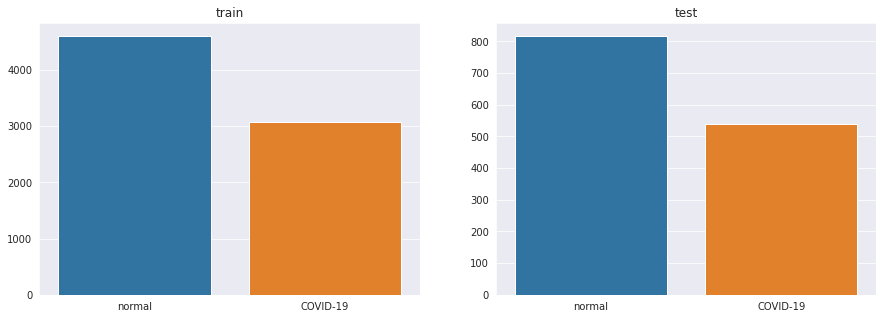

In [ ]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [ ]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


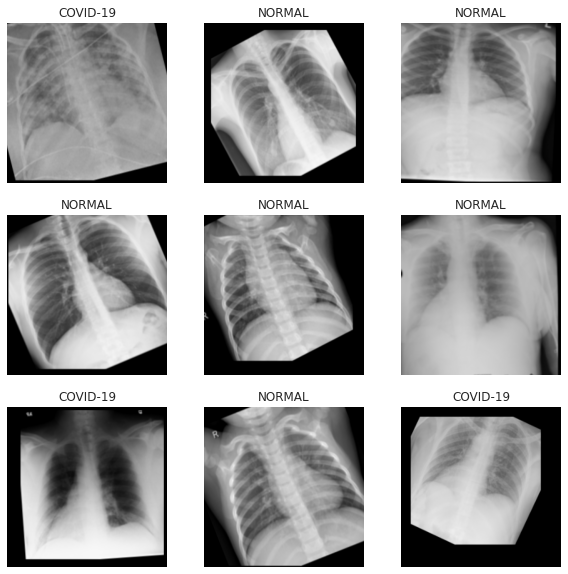

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

Define class weights

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [ ]:
learning_rate_decay = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.1, min_lr=1e-6)

## ResNet18V2 (DP-SGD)
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

In [ ]:
def resnet_block(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    preact = BatchNormalization(epsilon=1.001e-5, name=name + '_preact_bn')(x)
    preact = Activation('tanh', name=name + '_preact_tanh')(preact)
    if conv_shortcut is True:
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = MaxPooling2D(1, strides=stride)(x) if stride > 1 else x
    x = Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = Activation('tanh', name=name + '_1_tanh')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = Conv2D(filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = Activation('tanh', name=name + '_2_tanh')(x)
    x = Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = Add(name=name + '_out')([shortcut, x])
    return x

def resnet_stack(x, filters, blocks, stride1=2, name=None):
    x = resnet_block(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = resnet_block(x, filters, name=name + '_block' + str(i))
    x = resnet_block(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet(stack_fn, input, model_name='resnet'):
    x = ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(input)
    x = Conv2D(64, 7, strides=2, use_bias=True, name='conv1_conv')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = MaxPooling2D(3, strides=2, name='pool1_pool')(x)
    x = stack_fn(x)
    x = BatchNormalization(epsilon=1.001e-5, name='post_bn')(x)
    x = Activation('tanh', name='post_tanh')(x)
    # Create model
    model = tf.keras.models.Model(input, x, name=model_name)
    return model
    
def ResNet18V2(input):
    def stack_fn(x):
        x = resnet_stack(x, 16, 2, name='conv2')
        x = resnet_stack(x, 32, 2, name='conv3')
        x = resnet_stack(x, 64, 2, name='conv4')
        x = resnet_stack(x, 128, 2, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, input, 'resnet18v2')

In [ ]:
def resnet18_builder():
    # get ResNet18V2 without head
    resnet18 = ResNet18V2(Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    
    model = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        resnet18, # add resnet18 to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dropout(0.2, name='Dropout'), # add dropout (inspired by inception-resnet-v2)
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name='ResNet18V2')

    return model

In [ ]:
resnet18 = resnet18_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet18.compile(
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3 # public was: 1e-5
    ),
    loss=BinaryCrossentropy(
        from_logits=True, # TODO difference in attacks?
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [ ]:
resnet18.summary()

Model: "ResNet18V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet18v2 (Functional)      (None, 8, 8, 512)         897088    
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 512)               0         
_________________________________________________________________
Dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 513       
Total params: 897,601
Trainable params: 891,713
Non-trainable params: 5,888
_________________________________________________________________


### Training

In [ ]:
history_resnet18 = resnet18.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20
480/480 [==============================] - 258s 440ms/step - loss: 0.6756 - accuracy: 0.6221 - precision: 0.5301 - recall: 0.6009
Epoch 2/20
480/480 [==============================] - 202s 420ms/step - loss: 0.8411 - accuracy: 0.6808 - precision: 0.5950 - recall: 0.6627
Epoch 3/20
480/480 [==============================] - 202s 420ms/step - loss: 0.9201 - accuracy: 0.6856 - precision: 0.5997 - recall: 0.6570
Epoch 4/20
480/480 [==============================] - 201s 419ms/step - loss: 0.9907 - accuracy: 0.7006 - precision: 0.6215 - recall: 0.6651
Epoch 5/20
480/480 [==============================] - 201s 418ms/step - loss: 0.9703 - accuracy: 0.7072 - precision: 0.6308 - recall: 0.6799
Epoch 6/20
480/480 [==============================] - 202s 421ms/step - loss: 0.9971 - accuracy: 0.6990 - precision: 0.6229 - recall: 0.6649
Epoch 7/20
480/480 [==============================] - 200s 418ms/step - loss: 1.0053 - accuracy: 0.7033 - precision: 0.6283 - recall: 0.6690
Epoch 8/20
48

### Evaluation

###### Visualize performance

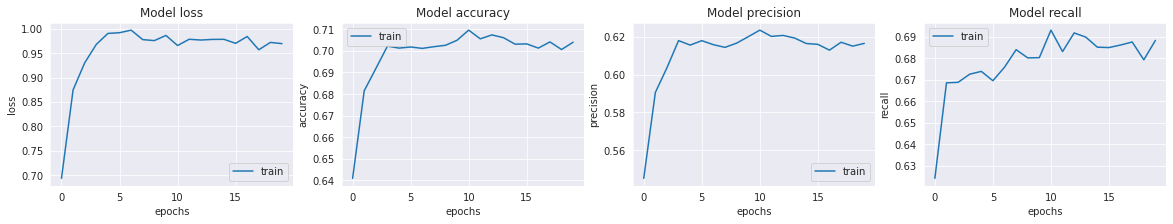

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet18.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet18.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

85/85 [==============================] - 20s 42ms/step - loss: 1.1518 - accuracy: 0.7063 - precision: 0.6002 - recall: 0.8018
Loss of the model is -  1.1911743879318237
Accuracy of the model is -  70.20648717880249 %
Precision of the model is -  0.591093122959137
Recall of the model is -  0.8126159310340881


## Privacy

### Compute epsilon

In [ ]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-4

In [ ]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [ ]:
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-04, Epsilon = 2.001


In [ ]:
# get needed noise for target epsilon
min_noise = 1e-5
target_epsilon = 2.0
compute_noise(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    target_epsilon,
    EPOCHS,
    DELTA,
    min_noise
)

DP-SGD with sampling rate = 0.208% and noise_multiplier = 0.7601405892956258 iterated over 9605 steps satisfies differential privacy with eps = 2 and delta = 0.0001.


0.7601405892956258

### Attacks

###### Model Inversion Attack

In [ ]:
# save weights
#resnet18.save_weights('inversion-dpsgd-resnet18-eps2.h5')
# load weights
resnet18.load_weights('inversion-dpsgd-resnet18-eps2.h5') #, by_name=True)

In [ ]:
while True: pass

In [233]:
def invert_model(model, max_iter, lr, img, init='random', pred_cutoff= 0.99, disp_freq=1, disp_img=False):
    # expected label
    probs = model.predict(img)[0][0]
    label = np.round(probs)
    # initial inversion image
    if init == 'zero':
        current_x = np.copy(img) # save batching
        current_x[0] = np.zeros(img[0].shape)
    elif init == 'random':
        current_x = np.copy(img) # save batching
        current_x[0] = np.random.rand(img[0].shape[0],
                                   img[0].shape[1],
                                   img[0].shape[2])
    
    current_probs = model.predict(current_x)[0][0]
    
    plt.imshow(current_x[0])
    plt.axis('off')
    plt.title('Initial inversion image')
    plt.show()
    print('Predictions for COVID-19 class: ' + str(current_probs))

    # simple cnn for inversion
    inversion_model = Sequential([
        Input(shape=img[0].shape),
        Dense(256, activation="relu"),
        Flatten(),
        Dense(1, activation='sigmoid'),
    ], name='InversionModel')
    optimizer = keras.optimizers.SGD(learning_rate=1e-3)
    loss_fn = BinaryCrossentropy(from_logits=False)

    print('Inversion started...')
    for i in range(1, max_iter+1):
        # get gradients and loss for current image
        with tf.GradientTape(persistent=False) as tape:
            x = tf.convert_to_tensor(current_x)
            tape.watch(x)
            logits = model(x, training=False)
            tape.watch(logits)
            loss = loss_fn(np.array([[label]]), logits)
            tape.watch(loss)
            gradient = tape.gradient(loss, x)
            grads = gradient

        # update current image
        current_x[0] = current_x[0] - lr * grads[0] # + or - ?
        current_x[0] = np.clip(current_x[0], 0.0, 1.0)
        #current_x[0] = current_x[0] * 1./255.
        
        current_probs = model.predict(current_x)[0][0]
        #cost = tf.abs(tf.subtract(label, current_probs))
        
        if pred_cutoff < current_probs:
            print("\n Above Probability Criteria!: {0}".format(current_probs))
            break
            
        if i%disp_freq ==0:
            if disp_img == True:
                plt.imshow(current_x[0])
                plt.axis('off')
                plt.title('Iteration %i' % (i))
                plt.show()
            print("\r Iteration %i - Probs: %.2f and Loss: %.4f" % (i, current_probs, loss))
          
    print('Inversion finished.')
    return current_x, current_probs

In [232]:
def perform_inversion(model, img, label):
    # original
    plt.imshow(img[0])
    plt.axis('off')
    if label[0] == 0:
        plt.title("Original image (NORMAL)")
    elif label[0] == 1:
        plt.title("Original image (COVID-19)")
    plt.show()
    print('Predictions for COVID-19 class: ' + str((model.predict(img))[0][0]))
    
    # inverse
    inv_img, inv_img_probs = invert_model(model, 
                                          max_iter=100, 
                                          lr=3, 
                                          img=img,
                                          init='random',
                                          disp_freq=25,
                                          disp_img=True)

    plt.imshow(inv_img[0])
    plt.axis('off')
    plt.title('Inversion image')
    plt.show()
    print('Predictions for COVID-19 class: ' + str(inv_img_probs))

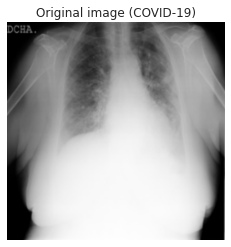

Predictions for COVID-19 class: 0.9688852


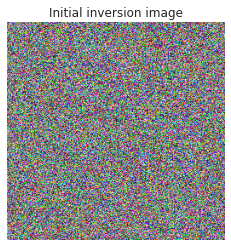

Predictions for COVID-19 class: 0.000101590595
Inversion started...


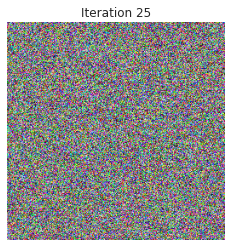

 Iteration 25 - Probs: 0.56 and Loss: 0.6205


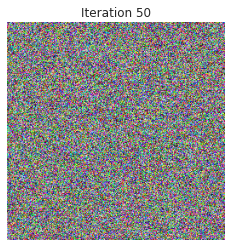

 Iteration 50 - Probs: 0.81 and Loss: 0.2154


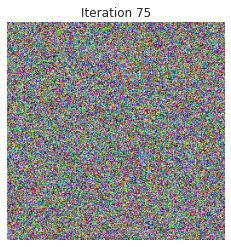

 Iteration 75 - Probs: 0.88 and Loss: 0.1278


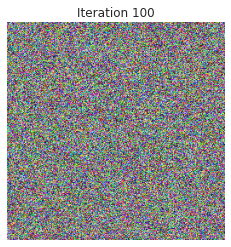

 Iteration 100 - Probs: 0.91 and Loss: 0.0914
Inversion finished.


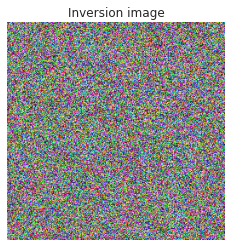

Predictions for COVID-19 class: 0.91358733


In [234]:
# use x_test_attack for batch size 1
for i, ex in enumerate(iter(x_test_attack)):
    image_batch, label_batch = ex
    if i == 1:
        break
    perform_inversion(resnet18, image_batch.numpy(), label_batch.numpy())